# Facility location

In [79]:
# Import libraries
from amplpy import AMPL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [80]:
# Read csv file
df = pd.read_csv('Crime_small.csv', index_col=0)
# Substract 1 from the index
df.index = df.index - 1
# The file consists of points in 2D space, the first column is the x coordinate and the second column is the y coordinate
# We calculate all the distances in the x-y plane
# We create a distance matrix
dist = np.zeros((len(df), len(df)))
for i in range(len(df)):
    for j in range(len(df)):
        dist[i][j] = np.sqrt((df.iloc[i][0] - df.iloc[j][0])**2 + (df.iloc[i][1] - df.iloc[j][1])**2)

# Create an AMPL instance
ampl = AMPL()

# Read the model file 
ampl.read("facility_location.mod")

# Add I and J sets
ampl.set['I'] = range(len(df))
ampl.set['J'] = range(len(df))
ampl.get_parameter("d").set_values(pd.DataFrame(dist).unstack())

# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "gurobi"
# Solve
ampl.solve()
# Print the objective value and X variable
print("Objective value: ", ampl.getObjective('cost').value())
# concatenate x values and df
df['active'] = ampl.getVariable('x').getValues().toPandas()
print("Facilities:")
df[df['active'] == 1].iloc[:,0:2]


Gurobi 10.0.1: Gurobi 10.0.1: optimal solution; objective 78.14985937
78 simplex iterations
1 branching nodes
Objective value:  78.14985936765767
Facilities:


,x,y
Point,,
4,10.983485,9.937429
5,-12.397562,2.040595
14,-1.285214,-2.635096


In [8]:
# Read excel file
df = pd.read_excel('Large_data.xlsx', index_col=0)
# Substract 1 from the index
df.index = df.index - 1
# The file consists of points in 2D space, the first column is the x coordinate and the second column is the y coordinate
# We calculate all the distances in the x-y plane
# We create a distance matrix
dist = np.zeros((len(df), len(df)))
for i in range(len(df)):
    for j in range(len(df)):
        dist[i][j] = np.sqrt((df.iloc[i][0] - df.iloc[j][0])**2 + (df.iloc[i][1] - df.iloc[j][1])**2)

# Create an AMPL instance
ampl = AMPL()

# Read the model file 
ampl.read("facility_location.mod")

# Add I and J sets
ampl.set['I'] = range(len(df))
ampl.set['J'] = range(len(df))
ampl.get_parameter("d").set_values(pd.DataFrame(dist).unstack())

# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "cplex"
# Solve
ampl.solve()
# Print the objective value and X variable
print("Objective value: ", ampl.getObjective('cost').value())
# concatenate x values and df
df['active'] = ampl.getVariable('x').getValues().toPandas()
df

CPLEX 22.1.1.0: optimal integer solution; objective 1080.273734
8550 MIP simplex iterations
0 branch-and-bound nodes
Objective value:  1080.2737337342596


,X,Y,active
0,-3.046828,1.399571,0.0
1,16.486402,0.537549,0.0
2,-7.997214,-0.105165,0.0
3,5.719701,17.760224,0.0
4,0.925597,-4.443022,0.0
...,...,...,...
195,1.652216,11.403096,0.0
196,-10.665481,-4.973736,0.0
197,2.172474,2.606369,0.0
198,-12.720324,-0.736628,1.0


In [9]:
df[df['active'] == 1]

,X,Y,active
83,8.932496,10.385036,1.0
94,0.432776,-1.162289,1.0
198,-12.720324,-0.736628,1.0


# K-means

In [81]:
# Read csv file
df = pd.read_csv('Crime_small.csv', index_col=0)
# Substract 1 from the index
df.index = df.index - 1

# Create an AMPL instance
ampl = AMPL()

# Read the model file 
ampl.read("k_means.mod")

# Add I and J sets
ampl.set['observations'] = range(len(df))
ampl.set['centroids'] = range(3)
ampl.get_parameter("observations_x").set_values(pd.DataFrame(df)['x'])
ampl.get_parameter("observations_y").set_values(pd.DataFrame(df)['y'])
# f)['y'])

# Specify the solver to use (e.g., HiGHS)
ampl.option["solver"] = "cplex"
# set non-default options for cplex
# print(ampl.get_option("gurobi_options"))
#show nodecount
ampl.option["gurobi_options"] = "outlev=1 bestbound=1"
ampl.setOption("show_nodecount", True)

# Solve
ampl.solve()
# Print the objective value
print("Objective value: ", ampl.getObjective('cost').value())
# print centroids
ampl.getVariable('centroids_x').getValues().toPandas()

Error:
	k_means.mod
	line 29 offset 1723
	p_lims_x is already defined
	context:  subject to  >>> p_lims_x  <<< {i in observations, j in centroids}: -3200 <= p[i, j] <= 3200; # auxiliary variable for assignment of observations to centroids
	
	Please report any bugs at: https://github.com/ampl/amplpy
	
	For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>
	


AMPLException: k_means.mod
line 29 offset 1723
p_lims_x is already defined
context:  subject to  >>> p_lims_x  <<< {i in observations, j in centroids}: -3200 <= p[i, j] <= 3200; # auxiliary variable for assignment of observations to centroids

Please report any bugs at: https://github.com/ampl/amplpy

For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>


In [12]:
x = list(np.array(ampl.getVariable('centroids_x').getValues().toPandas()['centroids_x.val']))
y = list(np.array(ampl.getVariable('centroids_y').getValues().toPandas()['centroids_y.val']))

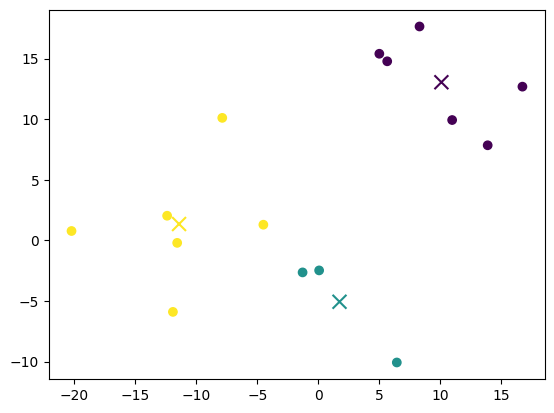

In [71]:
#plot the points
# plot the points, colored by cluster
c = ampl.getVariable('z').getValues().toPandas().unstack()
# make a new column of c, which multiplies the entrie times the column number
c['c'] = c.iloc[:, 0] * 0 + c.iloc[:, 1] * 1 + c.iloc[:, 2] * 2
# plot the points, colored by cluster, the colors should be red, green, and blue
plt.scatter(list(df['x']), list(df['y']), c=c['c'])
# plot the centroids
plt.scatter(x, y, c=[0, 1, 2], marker='x', s=100)


/Users/samo/mambaforge/envs/ML-comb-opt/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


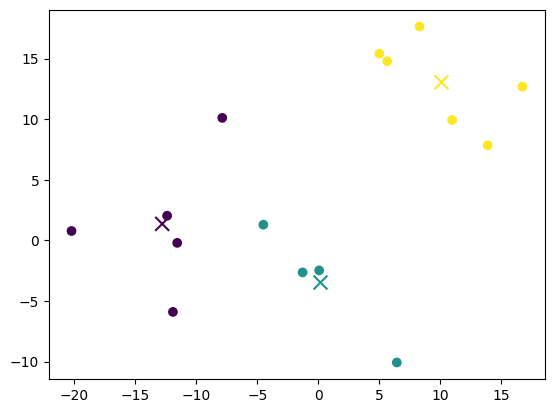

In [72]:
# apply k means to the data
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
# plot the points, colored by cluster
plt.scatter(list(df['x']), list(df['y']), c=kmeans.labels_)
# plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c=[0, 1, 2], marker='x', s=100)


In [74]:
kmeans.cluster_centers_[:, 0]

array([-12.80105937,   0.1822998 ,  10.10106867])

In [ ]:
# Read excel file
df = pd.read_csv('Crime_small.csv', index_col=0)
df['x']

Point
1     13.898617
2    -11.921480
3      6.444476
4     16.748870
5     10.983485
6    -12.397562
7     -4.502591
8      8.307953
9    -20.239902
10     5.656543
11   -11.572053
12     0.072528
13    -7.874300
14     5.010945
15    -1.285214
Name: x, dtype: float64

/Users/samo/mambaforge/envs/ML-comb-opt/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


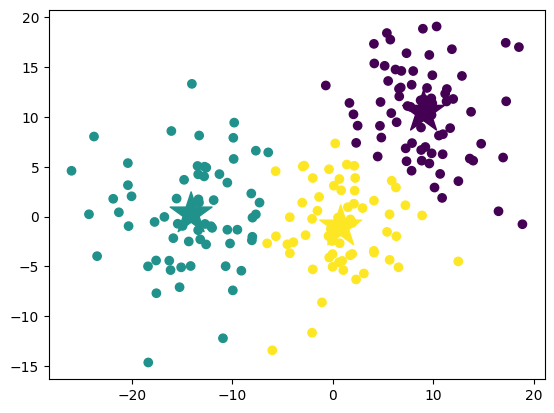

In [78]:
# Read excel file
df = pd.read_excel('Large_data.xlsx', index_col=0)
# Substract 1 from the index
df.index = df.index - 1
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
# plot the points, colored by cluster
plt.scatter(list(df['X']), list(df['Y']), c=kmeans.labels_)
# plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c=[0, 1, 2], marker='*', s=1000)

In [82]:
df

,X,Y
0,-3.046828,1.399571
1,16.486402,0.537549
2,-7.997214,-0.105165
3,5.719701,17.760224
4,0.925597,-4.443022
...,...,...
195,1.652216,11.403096
196,-10.665481,-4.973736
197,2.172474,2.606369
198,-12.720324,-0.736628
